## Introduction and Project Overview

This project is designed to be an engaging, hands-on experience in the world of machine learning and object detection. Our goal is to explore and compare the performance of different models in a dynamic, real-time environment.

## Problem Statement
In the realm of wildlife conservation and study, accurately identifying and monitoring different animal species is a significant challenge. Traditional methods are often labor-intensive and error-prone. This project addresses the need for an automated, accurate, and real-time animal detection system. By leveraging advanced object detection models, we aim to demonstrate the potential of AI in wildlife monitoring and study.

### Objective
We aim to deploy three different models to identify and classify animals in a live video. Our dataset focuses on five animal classes: Crocodile, Fox, Giraffe, Panda, and Raccoon. Each class has 100 images, culminating in a diverse set of 500 images.

### Models and Approach
We'll be using models from the Detectron2 framework, a state-of-the-art object detection library developed by Facebook AI Research. Our approach is as follows:
1. **Model Selection**: We'll select two pre-trained Detectron2 models to use as-is.
2. **Model Finetuning**: We'll finetune a third Detectron2 model on our custom animal dataset for a tailored approach.
3. **Real-Time Evaluation**: These models will be tested in real-time by processing a video that contains instances of our target animals. We'll assess and compare their performance based on accuracy and speed.

### Who is this for?
This notebook is designed for learners, enthusiasts, and professionals interested in machine learning, especially in the field of object detection. Whether you're a beginner or have some experience, you'll find this project insightful and challenging.

### Let's get started!
Follow along as we set up our environment, prepare our dataset, finetune our model, and dive into the exciting world of real-time object detection!

## Checking and Installing Required Libraries

In this section, we'll ensure that all the required libraries for our project are installed and ready to use. This includes PyTorch, torchvision, OpenCV, and Detectron2.

### 1. Verifying PyTorch and torchvision Installation

PyTorch is the backbone of our models, so it's essential to have it installed. Let's check if PyTorch and torchvision are already installed. If not, we'll install them.

In [1]:
import sys

# Function to install packages
def install_package(package_name):
    !{sys.executable} -m pip install {package_name}

# Check for PyTorch
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
except ImportError:
    print("PyTorch is not installed. Installing now...")
    install_package("torch torchvision")

# Check torchvision
try:
    import torchvision
    print(f"torchvision version: {torchvision.__version__}")
except ImportError:
    print("torchvision is not installed. Installing now...")
    install_package("torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

PyTorch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


### 2. Installing OpenCV and Checking CUDA Availability

Here we check for CUDA availability. If CUDA is available, PyTorch will use GPU acceleration, which will significantly speed up our training and inference. If CUDA is not available, PyTorch will use CPU. We'll also install OpenCV, which we'll use for video processing.

In [3]:
import torch

# Check for CUDA
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU acceleration!")
else:
    print("CUDA is not available. PyTorch is using CPU.")

try:
    import cv2
    print(f"OpenCV version: {cv2.__version__}")
except ImportError:
    print("OpenCV is not installed. Installing now...")
    install_package("opencv-python-headless")

CUDA is available. PyTorch is using GPU acceleration!
OpenCV version: 4.8.1


### 3. Installing Detectron2 from Source

Installing Detectron2 from source allows us to work with the latest version of the library. This method requires gcc & g++ (version 5.4 or higher). If you have these prerequisites, you can proceed with the installation; otherwise, please install them first.

In [4]:
# Install ninja for faster build
!pip install ninja

# Clone the Detectron2 repository
!python -m pip install git+https://github.com/facebookresearch/detectron2.git


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/facebookresearch/detectron2.git to c:\users\diego\appdata\local\temp\pip-req-build-8vbcbxwa
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git 'C:\Users\diego\AppData\Local\Temp\pip-req-build-8vbcbxwa'

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Note**: Building from source might take some time. If you encounter any issues, please refer to the [Detectron2 installation documentation](https://detectron2.readthedocs.io/en/latest/tutorials/install.html) for troubleshooting tips and alternative installation methods.

## Dataset Download and Preparation

This section focuses on downloading your custom animal dataset and preparing it for use with Detectron2.

### Downloading the Dataset

First, we need to download and extract the dataset from the provided link.

In [6]:
import requests
from zipfile import ZipFile
from io import BytesIO

# URL to the dataset
dataset_url = "https://github.com/D-Gaspa/Animal-BoVW-Classifier/releases/download/1.0/animals_dataset.zip"

# Download the dataset
response = requests.get(dataset_url)
zip_file = ZipFile(BytesIO(response.content))
# Create a folder to extract the dataset
!mkdir Dataset
# Extract the dataset to the created folder
zip_file.extractall("Dataset")
print("Dataset downloaded and extracted successfully!")

A subdirectory or file Dataset already exists.


Dataset downloaded and extracted successfully!


### Preparing the Dataset for Detectron2

Detectron2 requires the dataset to be in a specific format. We'll create a function to convert our dataset into this format.

In [7]:
import json
import os
from PIL import Image
import detectron2.structures

def get_my_dataset_dicts(dataset_dir, annotation_file):
    with open(annotation_file) as f:
        annotations = json.load(f)

    dataset_dicts = []
    for filename, objs in annotations.items():
        record = {}
        file_path = os.path.join(dataset_dir, filename)
        record["file_name"] = file_path

        image = Image.open(file_path)
        record["width"], record["height"] = image.size  # Ensure correct ordering

        record["annotations"] = []
        for obj in objs:
            obj["bbox_mode"] = detectron2.structures.BoxMode.XYWH_ABS
            record["annotations"].append(obj)

        dataset_dicts.append(record)

    return dataset_dicts

# Register the dataset
from detectron2.data import DatasetCatalog
DatasetCatalog.register("my_dataset", lambda: get_my_dataset_dicts("Dataset", "Dataset/annotations.json"))

print("Dataset registered successfully!")

Dataset registered successfully!


This function will format your dataset for Detectron2, considering the specific structure and annotation format of your dataset.

## Model Selection and Loading

In this part of our project, we will select and load pre-trained models from Detectron2's model zoo. Detectron2 offers a wide range of models that are pre-trained on various datasets. We will choose two distinct models for our initial comparison and later introduce a finetuned version of one of these models.

### Loading Pre-Trained Models

Detectron2 makes it easy to load pre-trained models. Here’s how you can do it:

In [46]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

def load_model(model_name):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_name))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
    predictor = DefaultPredictor(cfg)
    return predictor, cfg

# Example of loading two models
model_1, cfg_for_model_1 = load_model("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
print("Model 1 loaded successfully!")
model_2, cfg_for_model_2 = load_model("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")
print("Model 2 loaded successfully!")

[11/20 21:18:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...
Model 1 loaded successfully!
[11/20 21:18:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_DC5_3x/137849425/model_final_68d202.pkl ...
Model 2 loaded successfully!


### Choosing Different Models for Comparison

Detectron2’s model zoo contains a variety of models pre-trained on different datasets like COCO, Cityscapes, etc. When choosing models for comparison, consider the following:

- **Model Architecture**: Different architectures like Faster R-CNN, Mask R-CNN have their own strengths and weaknesses.
- **Backbone**: The backbone (like ResNet-50, ResNet-101) impacts the model's accuracy and speed.
    - FPN: Uses a ResNet+FPN backbone with standard conv and FC heads for mask and box prediction, respectively. It obtains the best speed/accuracy tradeoff.
    - DC5 (Dilated-C5): Uses a ResNet conv5 backbone with dilations in conv5, and standard conv and FC heads for mask and box prediction, respectively.

You can explore the [Detectron2 model zoo](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) to see all available options.

## Finetuning the Model

Finetuning a pre-trained model involves adjusting it slightly to perform better on our specific dataset. We will select one of the pre-trained models and retrain it on our animal dataset.

### Steps for Finetuning

1. **Load a Pre-Trained Model**: First, load a model from Detectron2's model zoo as a starting point.

2. **Modify for Our Dataset**: Since our dataset has 5 classes, we need to adjust the model's final layer to reflect this.

3. **Retrain the Model**: Finally, we'll retrain the model on our dataset.

In [43]:
from detectron2.engine import DefaultTrainer

def finetune_model(model_name, dataset_name, num_classes):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_name))
    cfg.DATASETS.TRAIN = (dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2 
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name) 
    cfg.SOLVER.IMS_PER_BATCH = 2 # IMS = Images per batch
    cfg.SOLVER.BASE_LR = 0.00025 # LR = Learning Rate
    cfg.SOLVER.MAX_ITER = 5000 # No. of iterations
    cfg.SOLVER.STEPS = []  # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # No. of RoIs per image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  # 5 classes for our dataset
    cfg.OUTPUT_DIR = "output"

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

# Fine-tuning the Faster R-CNN with a ResNet-50 backbone model on our dataset
finetune_model("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", "my_dataset", 5)

[11/20 20:32:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[11/20 20:32:38 d2.engine.train_loop]: Starting training from iteration 0
[11/20 20:32:46 d2.utils.events]:  eta: 0:21:00  iter: 19  total_loss: 3.352  loss_cls: 1.815  loss_box_reg: 0.0001535  loss_rpn_cls: 1.175  loss_rpn_loc: 0.3243    time: 0.2539  last_time: 0.2922  data_time: 0.1125  last_data_time: 0.0010   lr: 4.9953e-06  max_mem: 3436M
[11/20 20:32:51 d2.utils.events]:  eta: 0:20:39  iter: 39  total_loss: 3.049  loss_cls: 1.611  loss_box_reg: 0.008153  loss_rpn_cls: 1.117  loss_rpn_loc: 0.1737    time: 0.2503  last_time: 0.2383  data_time: 0.0011  last_data_time: 0.0012   lr: 9.9902e-06  max_mem: 3436M
[11/20 20:32:56 d2.utils.events]:  eta: 0:20:28  iter: 59  total_loss: 2.594  loss_cls: 1.289  loss_box_reg: 0.03154  loss_rpn_cls: 1.063  loss_rpn_loc: 0.2602    time: 0.2486  last_time: 0.2753  data_time: 0.0010  last_data_time: 0.0011   lr: 1.4985e-05  max_mem: 3596M
[11/20 20:33:01 d2.utils.events]:  eta: 0:20:19  iter: 79  total_loss: 1.896  loss_cls: 0.8051  loss_box_reg: 

## Real-Time Model Competition Setup

This section focuses on setting up a real-time competition between the models using a video of animals. We'll download the video and its annotations, process the video in real-time, and display the predictions. This will allow us to compare the models' performance in a dynamic environment.

### Downloading the Video and Annotations

First, let's download the video and its annotations:

In [12]:
# Video and annotations URLs
video_url = "https://github.com/D-Gaspa/Animal-BoVW-Classifier/releases/download/1.0/animals_video.zip"

# Download the video and annotations
response = requests.get(video_url)
zip_file = ZipFile(BytesIO(response.content))
# Create a folder to extract the video and annotations
!mkdir video_data
# Extract the video and annotations to the created folder
zip_file.extractall("video_data")

A subdirectory or file video_data already exists.


### Real-Time Processing and Display

Next, we'll process the video in real-time and display the predictions:

In [56]:
import cv2
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog

# Function to load the finetuned model
def load_finetuned_model(weights_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Adjust based on your dataset
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # Set threshold for this model
    return DefaultPredictor(cfg), cfg

# Load the finetuned model
finetuned_model, finetuned_cfg = load_finetuned_model("output/model_final.pth")

video = cv2.VideoCapture("video_data/animals_video.mp4")

# Initialize lists to store results
results_model_1 = []
results_model_2 = []
results_finetuned = []

frame_count = 0  # To keep track of the frame number

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.resize(frame, (960, 540))  # Resize frame
    
    outputs_1 = model_1(frame)
    outputs_2 = model_2(frame)
    finetuned_outputs = finetuned_model(frame)
    
    # Store the outputs along with the frame number
    results_model_1.append((frame_count, outputs_1))
    results_model_2.append((frame_count, outputs_2))
    results_finetuned.append((frame_count, finetuned_outputs))

    v1 = Visualizer(frame, MetadataCatalog.get("my_dataset"), scale=0.5, instance_mode=ColorMode.IMAGE)
    v2 = Visualizer(frame, MetadataCatalog.get("my_dataset"), scale=0.5, instance_mode=ColorMode.IMAGE)
    v3 = Visualizer(frame, MetadataCatalog.get("my_dataset"), scale=0.5, instance_mode=ColorMode.IMAGE)

    out1 = v1.draw_instance_predictions(outputs_1["instances"].to("cpu")).get_image()
    out2 = v2.draw_instance_predictions(outputs_2["instances"].to("cpu")).get_image()
    out3 = v3.draw_instance_predictions(finetuned_outputs["instances"].to("cpu")).get_image()

    # Label the outputs
    out1 = cv2.putText(out1, "Model 1", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    out2 = cv2.putText(out2, "Model 2", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    out3 = cv2.putText(out3, "Finetuned Model", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Combine outputs for side-by-side comparison
    combined_output = cv2.hconcat([out1, out2, out3])
    cv2.imshow("Model Comparisons", combined_output)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    frame_count += 1
        
video.release()
cv2.destroyAllWindows()


[11/20 23:39:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...


## Evaluation and Reporting

### Step 1: Load Ground Truth Annotations

In [57]:
# print the results to see the format
print(results_model_1)

print(results_model_2)

print(results_finetuned)

[(0, {'instances': Instances(num_instances=1, image_height=540, image_width=960, fields=[pred_boxes: Boxes(tensor([[328.9834, 140.5919, 440.0360, 538.2921]], device='cuda:0')), scores: tensor([0.9981], device='cuda:0'), pred_classes: tensor([23], device='cuda:0')])}), (1, {'instances': Instances(num_instances=1, image_height=540, image_width=960, fields=[pred_boxes: Boxes(tensor([[328.6571, 143.7304, 439.6334, 536.4116]], device='cuda:0')), scores: tensor([0.9981], device='cuda:0'), pred_classes: tensor([23], device='cuda:0')])}), (2, {'instances': Instances(num_instances=1, image_height=540, image_width=960, fields=[pred_boxes: Boxes(tensor([[330.1905, 131.4164, 443.1016, 536.8411]], device='cuda:0')), scores: tensor([0.9979], device='cuda:0'), pred_classes: tensor([23], device='cuda:0')])}), (3, {'instances': Instances(num_instances=1, image_height=540, image_width=960, fields=[pred_boxes: Boxes(tensor([[329.9726, 136.9312, 443.4312, 537.6895]], device='cuda:0')), scores: tensor([0.9

### Step 2: Compare Predictions with Ground Truth
We'll create a function to compare the model predictions against the ground truth annotations. This function will calculate metrics such as Precision, Recall, and F1 Score.

In [53]:
import xml.etree.ElementTree as ET

def parse_xml_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    annotations = {}
    for track in root.findall('.//track'):
        label = track.get('label')
        for box in track.findall('./box'):
            frame = int(box.get('frame'))
            xtl = float(box.get('xtl'))
            ytl = float(box.get('ytl'))
            xbr = float(box.get('xbr'))
            ybr = float(box.get('ybr'))
            bbox = [xtl, ytl, xbr, ybr]

            if frame not in annotations:
                annotations[frame] = []
            annotations[frame].append({'bbox': bbox, 'label': label})
    
    return annotations

annotations = parse_xml_annotations('annotations.xml')

def calculate_iou(box1, box2):
    # Unpack the coordinates
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the (x, y)-coordinates of the intersection rectangle
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    # Compute the area of intersection rectangle
    inter_area = max(0, x_inter_max - x_inter_min + 1) * max(0, y_inter_max - y_inter_min + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = (x1_max - x1_min + 1) * (y1_max - y1_min + 1)
    box2_area = (x2_max - x2_min + 1) * (y2_max - y2_min + 1)

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the interesection area
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou


def match_predictions_with_annotations(predictions, annotations, iou_threshold=0.5):
    TP, FP, FN = 0, 0, 0
    
    for frame_number, prediction in predictions:
        frame_annotations = annotations.get(frame_number, [])
        matched = [False] * len(frame_annotations)

        if prediction is not None:
            pred_boxes = prediction['instances'].pred_boxes.tensor.cpu().numpy()
            for pred_box in pred_boxes:
                best_iou = 0
                best_match = -1

                for i, annotation in enumerate(frame_annotations):
                    iou = calculate_iou(pred_box, annotation['bbox'])

                    if iou > best_iou:
                        best_iou = iou
                        best_match = i

                if best_iou >= iou_threshold:
                    matched[best_match] = True
                else:
                    FP += 1

        FN += matched.count(False)
        TP += sum(matched)

    return TP, FP, FN

def calculate_metrics(TP, FP, FN):
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1_score

# Example evaluation for Model 1
TP_model_1, FP_model_1, FN_model_1 = match_predictions_with_annotations(results_model_1, annotations)
precision_model_1, recall_model_1, f1_model_1 = calculate_metrics(TP_model_1, FP_model_1, FN_model_1)

# Example evaluation for Model 2
TP_model_2, FP_model_2, FN_model_2 = match_predictions_with_annotations(results_model_2, annotations)
precision_model_2, recall_model_2, f1_model_2 = calculate_metrics(TP_model_2, FP_model_2, FN_model_2)

# Example evaluation for Finetuned Model
TP_finetuned, FP_finetuned, FN_finetuned = match_predictions_with_annotations(results_finetuned, annotations)
precision_finetuned, recall_finetuned, f1_finetuned = calculate_metrics(TP_finetuned, FP_finetuned, FN_finetuned)

### Step 3: Visualize and Compare Results
Visualize the results of the evaluation to compare the models' performances.

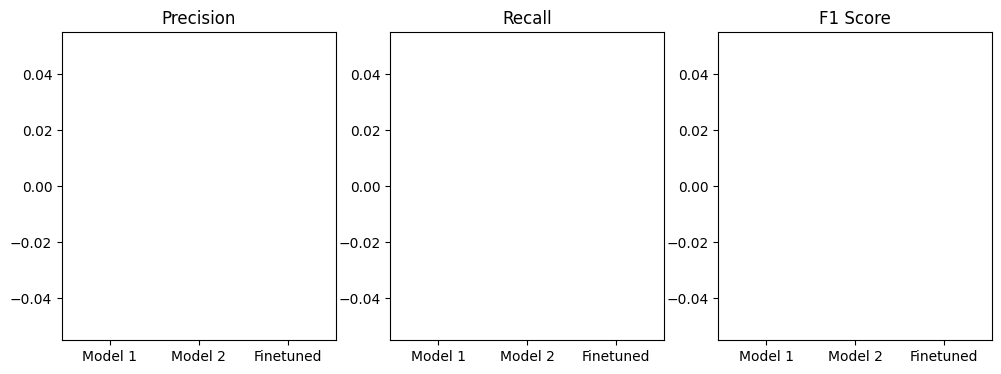

In [54]:
import matplotlib.pyplot as plt

# Assuming you've calculated metrics for all models
precisions = [precision_model_1, precision_model_2, precision_finetuned]
recalls = [recall_model_1, recall_model_2, recall_finetuned]
f1_scores = [f1_model_1, f1_model_2, f1_finetuned]

# Create bar plots for each metric
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(['Model 1', 'Model 2', 'Finetuned'], precisions)
plt.title('Precision')

plt.subplot(1, 3, 2)
plt.bar(['Model 1', 'Model 2', 'Finetuned'], recalls)
plt.title('Recall')

plt.subplot(1, 3, 3)
plt.bar(['Model 1', 'Model 2', 'Finetuned'], f1_scores)
plt.title('F1 Score')

plt.show()

### Conclusion
This section will give us insights into the performance of each model in detecting animals in real-time, guiding future improvements.